(cov-ind-time-notebook)=
# Covariate indipendenti dal tempo

Partendo dai modelli di crescita lineare descritti nei capitoli precedenti, ci chiediamo se le differenze individuali nelle traiettorie di cambiamento siano associate ad altre variabili. Questo capitolo introduce modelli che esaminano se la variabilità nell’intercetta e nella pendenza del modello di crescita lineare può essere spiegata da covariate invarianti nel tempo. Queste sono variabili a livello di persona che non cambiano nel tempo, come il genere, le condizioni sperimentali e lo stato socio-economico. Nel contesto dei modelli a crescita latente, tali variabili vengono considerate come variabili indipendenti in un modello di regressione multipla in cui l’intercetta e la pendenza del modello di crescita lineare sono le variabili dipendenti. Le covariate invarianti nel tempo possono essere continue, ordinali o categoriche.

Studiando come le differenze individuali nell’intercetta e nella pendenza sono correlate ad altre variabili a livello della persona, possiamo comprendere le possibili ragioni per cui gli individui cambiano in modi diversi. Tuttavia, i risultati di questi modelli non forniscono ulteriori inferenze sulla causalità rispetto ai tipici modelli di regressione. Gli utenti dovrebbero essere cauti quando discutono tali effetti e tenere presente se la covariata invariante nel tempo è stata assegnata in maniera casuale nel contesto di un protocollo sperimentale, oppure se i dati provengono da ricerche osservazionali.

In [27]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semPlot")
    library("knitr")
    library("markdown")
    library("patchwork")
    library("psych")
    library("DT")
    library("kableExtra")
    library("lme4")
})

set.seed(42)

Per questo esempio considereremo i dati di prestazione matematica dal data set NLSY-CYA Long Data [si veda {cite:t}`grimm2016growth`]. Iniziamo a leggere i dati.

In [28]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_long_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_long <- dat

# Add names the columns of the data set
names(nlsy_math_long) <- c(
  "id", "female", "lb_wght",
  "anti_k1", "math", "grade",
  "occ", "age", "men",
  "spring", "anti"
)

# view the first few observations in the data set
head(nlsy_math_long, 10)

,id,female,lb_wght,anti_k1,math,grade,occ,age,men,spring,anti
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,38,3,2,111,0,1,0
2,201,1,0,0,55,5,3,135,1,1,0
3,303,1,0,1,26,2,2,121,0,1,2
4,303,1,0,1,33,5,3,145,0,1,2
5,2702,0,0,0,56,2,2,100,NA,1,0
6,2702,0,0,0,58,4,3,125,NA,1,2
7,2702,0,0,0,80,8,4,173,NA,1,2
8,4303,1,0,0,41,3,2,115,0,0,1
9,4303,1,0,0,58,4,3,135,0,1,2


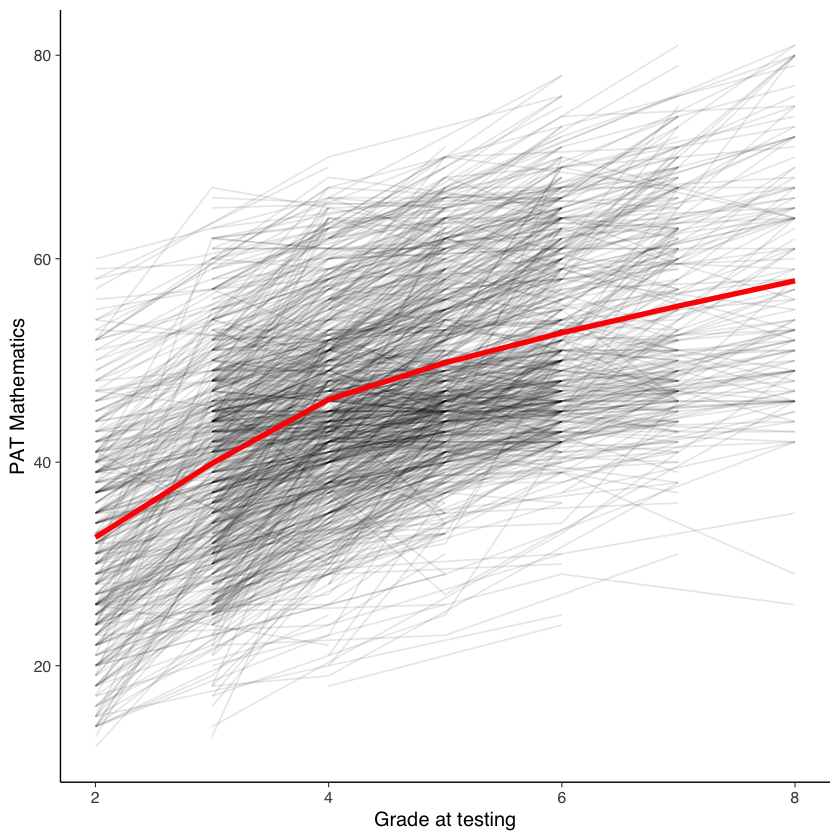

In [29]:
nlsy_math_long |>
  ggplot(
    aes(grade, math, group = id)
  ) +
  geom_line(alpha = 0.1) + # add individual line with transparency
  stat_summary( # add average line
    aes(group = 1),
    fun = mean,
    geom = "line",
    linewidth = 1.5,
    color = "red"
  ) +
  labs(x = "Grade at testing", y = "PAT Mathematics") 


Per vedere il cambiamento a livello individuale, possiamo campionare 20 individui e rappresentare per ognuno il loro cambiamento nel punteggio di matematica.

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


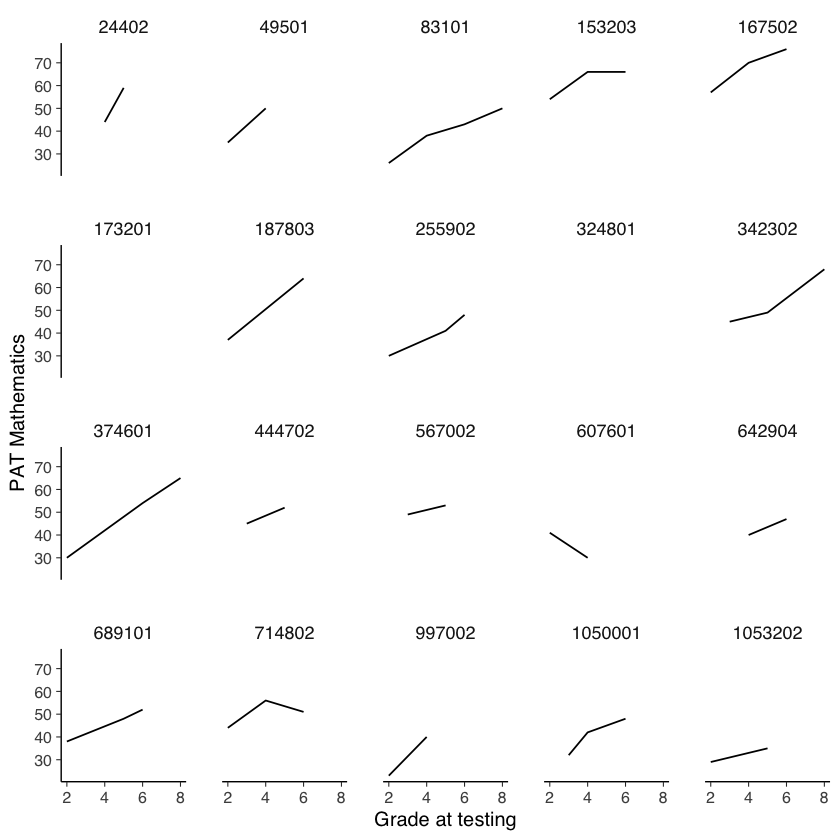

In [30]:
# sample 20 ids
people <- unique(nlsy_math_long$id) %>% sample(20)
# do separate graph for each individual
nlsy_math_long %>% 
  filter(id %in% people) %>%  # filter only sampled cases
  ggplot(aes(grade, math, group = 1)) +
  geom_line() +
  facet_wrap(~id) + # a graph for each individual
  labs(x = "Grade at testing", y = "PAT Mathematics") 

Per semplicità, leggiamo gli stessi dati in formato wide da un file.

In [12]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_wide_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_wide <- dat

# Give the variable names
names(nlsy_math_wide) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "age2", "age3", "age4", "age5", "age6", "age7", "age8",
  "men2", "men3", "men4", "men5", "men6", "men7", "men8",
  "spring2", "spring3", "spring4", "spring5", "spring6", "spring7", "spring8",
  "anti2", "anti3", "anti4", "anti5", "anti6", "anti7", "anti8"
)


# view the first few observations (and columns) in the data set
head(nlsy_math_wide[, 1:11], 10)

,id,female,lb_wght,anti_k1,math2,math3,math4,math5,math6,math7,math8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,NA,38,NA,55,NA,NA,NA
2,303,1,0,1,26,NA,NA,33,NA,NA,NA
3,2702,0,0,0,56,NA,58,NA,NA,NA,80
4,4303,1,0,0,NA,41,58,NA,NA,NA,NA
5,5002,0,0,4,NA,NA,46,NA,54,NA,66
6,5005,1,0,0,35,NA,50,NA,60,NA,59
7,5701,0,0,2,NA,62,61,NA,NA,NA,NA
8,6102,0,0,0,NA,NA,55,67,NA,81,NA
9,6801,1,0,0,NA,54,NA,62,NA,66,NA


Specifichiamo il modello SEM (si noti che, anche in questo caso, la scrittura del modello può essere semplificata usando la funzione `growth`).

In [13]:
#writing out linear growth model with tic in full SEM way 
lg_math_tic_lavaan_model <- '
    #latent variable definitions
            #intercept
              eta1 =~ 1*math2+
                      1*math3+
                      1*math4+
                      1*math5+
                      1*math6+
                      1*math7+
                      1*math8
            #linear slope
              eta2 =~ 0*math2+
                      1*math3+
                      2*math4+
                      3*math5+
                      4*math6+
                      5*math7+
                      6*math8

          #factor variances
            eta1 ~~ eta1
            eta2 ~~ eta2

          #factor covariance
            eta1 ~~ eta2

          #manifest variances (set equal by naming theta)
            math2 ~~ theta*math2
            math3 ~~ theta*math3
            math4 ~~ theta*math4
            math5 ~~ theta*math5
            math6 ~~ theta*math6
            math7 ~~ theta*math7
            math8 ~~ theta*math8

          #latent means (freely estimated)
            eta1 ~ 1
            eta2 ~ 1

          #manifest means (fixed to zero)
            math2 ~ 0*1
            math3 ~ 0*1
            math4 ~ 0*1
            math5 ~ 0*1
            math6 ~ 0*1
            math7 ~ 0*1
            math8 ~ 0*1

        #Time invariant covaraite
        #regression of time-invariant covariate on intercept and slope factors
            eta1 ~ lb_wght + anti_k1
            eta2 ~ lb_wght + anti_k1

        #variance of TIV covariates
            lb_wght ~~ lb_wght
            anti_k1 ~~ anti_k1

        #covariance of TIV covaraites
            lb_wght ~~ anti_k1

        #means of TIV covariates (freely estimated)
            lb_wght ~ 1
            anti_k1 ~ 1
' #end of model definition

Adattiamo il modello ai dati.

In [14]:
lg_math_tic_lavaan_fit <- sem(lg_math_tic_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some observed variances are (at least) a factor 1000 times larger than others; use varTable(fit) to investigate”
Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”
Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo la soluzione ottenuta.

In [15]:
summary(lg_math_tic_lavaan_fit, fit.measures = TRUE) |>
    print()

lavaan 0.6.15 ended normally after 107 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        21
  Number of equality constraints                     6

  Number of observations                           933
  Number of missing patterns                        61

Model Test User Model:
                                                      
  Test statistic                               220.221
  Degrees of freedom                                39
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               892.616
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.788
  Tucker-Lewis Index (TLI)                       0.805
                                  

Creiamo un diagramma di percorso.

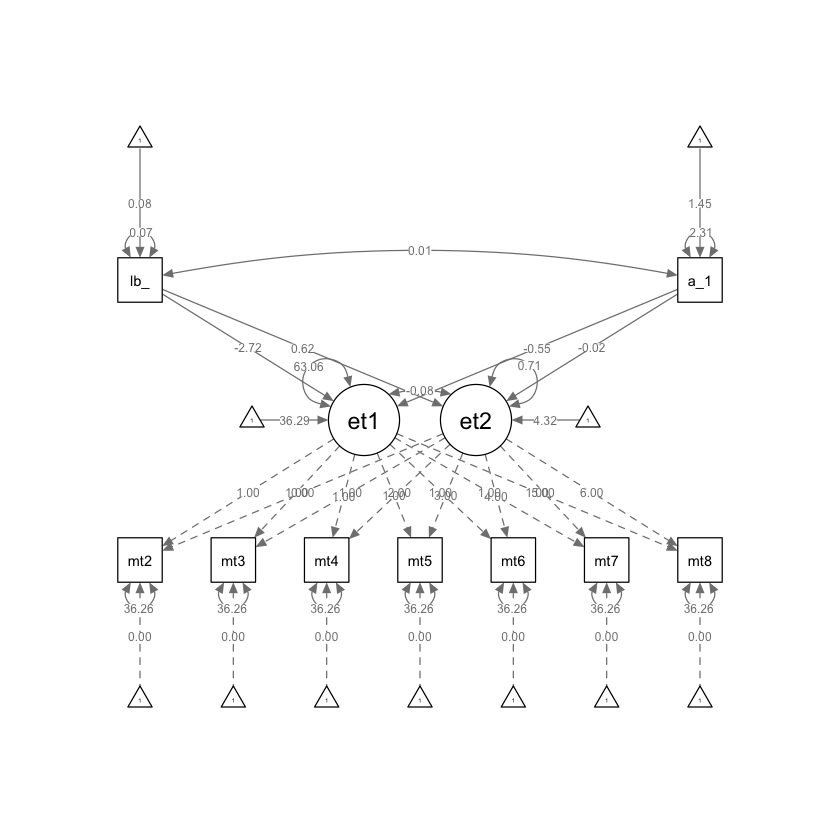

In [8]:
semPaths(lg_math_tic_lavaan_fit,what = "path", whatLabels = "par")

### Valutare il contributo delle covariate

Per valutare se le covariate considerate migliorano l'adattamento del modello, confronteremo il modello precedente con un modello vincolato in cui l'effetto delle covariate viene fissato a zero. 

In [16]:
#writing out linear growth model with tic in full SEM way 
lg_math_ticZERO_lavaan_model <- '
    #latent variable definitions
            #intercept
              eta1 =~ 1*math2+
                      1*math3+
                      1*math4+
                      1*math5+
                      1*math6+
                      1*math7+
                      1*math8
            #linear slope
              eta2 =~ 0*math2+
                      1*math3+
                      2*math4+
                      3*math5+
                      4*math6+
                      5*math7+
                      6*math8

          #factor variances
            eta1 ~~ eta1
            eta2 ~~ eta2

          #factor covariance
            eta1 ~~ eta2

          #manifest variances (set equal by naming theta)
            math2 ~~ theta*math2
            math3 ~~ theta*math3
            math4 ~~ theta*math4
            math5 ~~ theta*math5
            math6 ~~ theta*math6
            math7 ~~ theta*math7
            math8 ~~ theta*math8

          #latent means (freely estimated)
            eta1 ~ 1
            eta2 ~ 1

          #manifest means (fixed to zero)
            math2 ~ 0*1
            math3 ~ 0*1
            math4 ~ 0*1
            math5 ~ 0*1
            math6 ~ 0*1
            math7 ~ 0*1
            math8 ~ 0*1

        #Time invariant covaraite
          #regression of time-invariant covariate on intercept and slope factors
          #FIXED to 0
            eta1 ~ 0*lb_wght + 0*anti_k1
            eta2 ~ 0*lb_wght + 0*anti_k1

        #variance of TIV covariates
            lb_wght ~~ lb_wght
            anti_k1 ~~ anti_k1

        #covariance of TIV covaraites
            lb_wght ~~ anti_k1

        #means of TIV covariates (freely estimated)
            lb_wght ~ 1
            anti_k1 ~ 1
' #end of model definition

Adattiamo il modello ai dati.

In [17]:
lg_math_ticZERO_lavaan_fit <- sem(lg_math_ticZERO_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some observed variances are (at least) a factor 1000 times larger than others; use varTable(fit) to investigate”
Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”
Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo il risultato ottenuto. 

In [18]:
summary(lg_math_ticZERO_lavaan_fit, fit.measures = TRUE) |>
    print()

lavaan 0.6.15 ended normally after 92 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        17
  Number of equality constraints                     6

  Number of observations                           933
  Number of missing patterns                        61

Model Test User Model:
                                                      
  Test statistic                               234.467
  Degrees of freedom                                43
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               892.616
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.776
  Tucker-Lewis Index (TLI)                       0.813
                                   

Generiamo il diagramma di percorso.

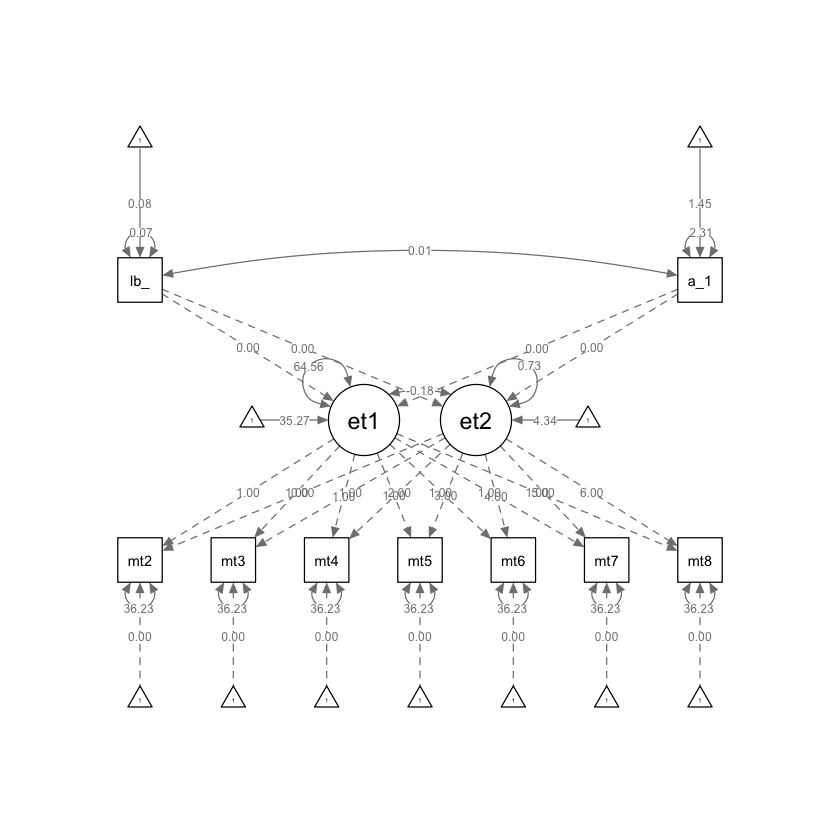

In [19]:
semPaths(lg_math_ticZERO_lavaan_fit, what = "path", whatLabels = "par")

Eseguiamo il confronto tra i due modelli mediante il test del rapporto tra verosimiglianze.

In [20]:
lavTestLRT(lg_math_tic_lavaan_fit, lg_math_ticZERO_lavaan_fit) |>
    print()

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
lg_math_tic_lavaan_fit,39,19600.17,19672.75,220.2212,NA,NA,NA,NA
lg_math_ticZERO_lavaan_fit,43,19606.42,19659.64,234.4666,14.24534,0.05239531,4,0.006551826


Il valore-p associato alla statistica chi-quadrato relativa alla differenza tra i due modelli è piccolo. Questo significa che i vincoli aggiuntivi hanno impattato in maniera sostanziale la bontà di adattamento del modello ai dati. Da ciò concludiamo che le covariate forniscono un contributo utile al modello.

## Confronto con il modello misto

Eseguiamo l’analisi utilizzando un modello misto con intercetta e pendenza casuale. Confronteremo un modello ridotto, che include solo l’effetto del tempo, con un modello completo che include le covariate esaminate in precedenza. Il modello completo include gli effetti principali delle covariate e l’interazione tra le covariate e il tempo.

Adattiamo il modello "completo".

In [5]:
nlsy_math_long$grade_c2 <- nlsy_math_long$grade-2

fit2_lmer <- lmer(
    math ~ 1 + grade_c2 + lb_wght + anti_k1 + I(grade_c2 * lb_wght) + I(grade_c2 * anti_k1) +
        (1 + grade_c2 | id),
    data = nlsy_math_long,
    REML = FALSE,
    na.action = na.exclude
)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00577356 (tol = 0.002, component 1)”


Esaminiamo i risultati ottenuti.

In [6]:
summary(fit2_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: math ~ 1 + grade_c2 + lb_wght + anti_k1 + I(grade_c2 * lb_wght) +  
    I(grade_c2 * anti_k1) + (1 + grade_c2 | id)
   Data: nlsy_math_long

     AIC      BIC   logLik deviance df.resid 
 15943.1  16000.2  -7961.6  15923.1     2211 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.07986 -0.52517 -0.00867  0.53079  2.53455 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 id       (Intercept) 63.0652  7.941         
          grade_c2     0.7141  0.845    -0.01
 Residual             36.2543  6.021         
Number of obs: 2221, groups:  id, 932

Fixed effects:
                      Estimate Std. Error t value
(Intercept)           36.28983    0.49630  73.120
grade_c2               4.31521    0.12060  35.782
lb_wght               -2.71621    1.29359  -2.100
anti_k1               -0.55087    0.23246  -2.370
I(grade_c2 * lb_wght)  0.62463    0.33314   1.875
I(grade_c2 * anti_k1) -0.01930   

Adattiamo un modello misto vincolato senza covariate, utilizzando un modello con intercetta e pendenza casuale.

In [7]:
fit3_lmer <- lmer(
    math ~ 1 + grade_c2 + (1 + grade_c2 | id),
    data = nlsy_math_long,
    REML = FALSE,
    na.action = na.exclude
)

Confrontiamo i due modelli utilizzando il test del rapporto di verosimiglianza.

In [8]:
lavTestLRT(fit2_lmer, fit3_lmer) |>
    print()

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fit3_lmer,6,15949.39,15983.62,-7968.693,15937.39,NA,NA,NA
fit2_lmer,10,15943.14,16000.20,-7961.570,15923.14,14.24533,4,0.006551848


Il risultato è sostanzialmente identico a quello ottenuto con il modello LGM.